In [1]:
import random
import timeit
import os
from Bio import SeqIO
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.stats import entropy
%matplotlib inline

def count_residues_in_sequence(sequence, residue):
    residue_count = 0
    residue_count += sequence.count(residue)
    return residue_count

def get_observed_values(sequence_1, sequence_2):
    obs = np.zeros((2, 20))
    fracsall1 = list()
    for res in ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']:
        count = count_residues_in_sequence(sequence_1, res)
        fraction = count / len(sequence_1)
        fracsall1.append(fraction * 1000)
    obs[0] = fracsall1
    fracsall2 = list()
    for res in ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']:
        count = count_residues_in_sequence(sequence_2, res)
        fraction = count / len(sequence_2)
        fracsall2.append(fraction * 1000)
    obs[1] = fracsall2
    return obs

def get_expected_values(observed_values):
    exp = np.zeros((2,20))
    for seqs in [0,1]:
        for res in range(0,20):
            exp[seqs,res] = (observed_values[0,res]+observed_values[1,res])*0.5
    return exp

def get_residue_conts(observed_values, expected_values):
    conts = np.zeros((2,20))
    for seqs in [0,1]:
        for res in range(0,20):
            if expected_values[seqs,res] == 0:
                conts[seqs,res] = 0
            else:
                conts[seqs,res] = ((observed_values[seqs,res]-expected_values[seqs,res])**2) / expected_values[seqs,res]
    conts_t = conts.transpose()
    res_conts = np.zeros((1,20))
    for res in range(0,20):
        res_conts[0, res] = sum(conts_t[res,:])
    return res_conts

def get_chi_score(residue_conts):
    return residue_conts.sum() / 2000

def calculate_chi_score(sequence_1, sequence_2):
    obs = get_observed_values(sequence_1, sequence_2)
    exp = get_expected_values(obs)
    res_conts = get_residue_conts(obs, exp)
    return get_chi_score(res_conts)
    
def get_heatmap_scores(sequence, window):
    slen = len(sequence)
    nwin = slen - (window - 1)
    seqs = list()
    for windows in range(0, nwin):
        subseq = sequence[windows:windows+window]
        seqs.append(subseq)
    scores = np.zeros((nwin, nwin))
    for x in range(0, nwin):
        for y in range(0, nwin):
            scores[x,y] = calculate_chi_score(seqs[x], seqs[y])
    return(scores)

def get_corr_scores(scores):
    df = pd.DataFrame(scores)
    dfcorr = df.corr()
    corr_scores = dfcorr.to_numpy()
    return corr_scores

## New Instulation Score Definition

def get_insulation_scores(data, ins_window):
    scores = data 
    window_range = np.arange(ins_window, len(scores)-(ins_window), 1)
    insulation_scores = list()
    for x in window_range:
        windowa = list()
        windowb = list()
        if x == window_range[0]:
            for y in np.arange(1, ins_window+1, 1):
                windowa.append(scores[x-y,x+y])
            insulation_scores.append(np.mean(windowa))
        else:
            for y in np.arange(0, ins_window, 1):
                windowa.append(scores[x-y-1, x+y])
            insulation_scores.append(np.mean(windowa))
            for y in np.arange(1, ins_window+1, 1):
                windowb.append(scores[x-y, x+y])
            insulation_scores.append(np.mean(windowb))   
    return insulation_scores

def ins_to_residues(ins_numbers, chi_window):
    residues = list()
    for ins in ins_numbers:
        residues.append(ins+((chi_window-1)/2))
    return residues

def get_region_scores(sequence, optimized_nodes):
    boundaries = [0]
    for node in optimized_nodes:
        if int(node) not in boundaries:
            boundaries.append(int(node))
    boundaries.append(len(sequence))
    if len(boundaries) == 2:
        return 0
    else:
        nregions = len(boundaries) - 1
        regions = list()
        for region in range(0, nregions):
            regions.append(sequence[boundaries[region]:boundaries[region + 1]])
        scores = list()
        for x in range(0, nregions):
            for y in range(0, nregions):
                if y == x - 1:
                    if len(regions[x]) < 1 or len(regions[y]) < 1:
                        scores.append(0)
                    else:
                        scores.append(calculate_chi_score(regions[x], regions[y]))
        return scores
    
def get_modules(sequence, boundaries):
    bounds = [0]
    for bound in boundaries:
        bounds.append(bound)
    bounds.append(len(sequence))
    modules = list()
    for x in np.arange(1, len(bounds), 1):
        modules.append(sequence[int(bounds[x-1]):int(bounds[x])])
    return modules

def optimize_boundaries(sequence, groups):
    start_sols = list()
    for group in groups:
        if group[0] == 0:
            start_sols.append(group[1])
        else:
            start_sols.append(group[0])
    while len(start_sols) < 3:
        start_sols.append(0)
    count = 0
    if len(groups) >= 3:
        end = 2
    elif len(groups) == 2:
        end = 1
    else:
        end = 0
    while count < len(groups)-end:
        xs = groups[count]
        if len(groups) >= 2:
            ys = groups[count+1]
        else:
            ys = [0]
        if len(groups) >= 3:
            zs = groups[count+2]
        else:
            zs = [0]
        scores = np.zeros((len(xs), len(ys), len(zs)))
        for x in np.arange(0, len(xs), 1):
            for y in np.arange(0, len(ys), 1):
                for z in np.arange(0, len(zs), 1):
                    start_sols[count], start_sols[count+1], start_sols[count+2] = xs[x], ys[y], zs[z]
                    scores[x, y, z] = np.mean(get_region_scores(sequence, start_sols))
        best_index = np.column_stack(np.where(scores == np.max(scores)))
        start_sols[count], start_sols[count+1], start_sols[count+2] = xs[best_index[0][0]], ys[best_index[0][1]], zs[best_index[0][2]]
        count = count + 1
    optimized_sols = list()
    for boundary in start_sols:
        if boundary != 0:
            optimized_sols.append(boundary)
    return optimized_sols

def get_zscores(sequence, boundaries):
    bounds = [0]
    for node in boundaries:
        bounds.append(node)
    bounds.append(len(sequence))
    regions = list()
    for x in np.arange(1, len(bounds)-1, 1):
        regions.append([sequence[int(bounds[x-1]):int(bounds[x+1])], np.min([bounds[x]-bounds[x-1], bounds[x+1]-bounds[x]])])
    z_sets = list()
    for region in regions:
        count = 0
        # shortest_mod = int(region[1]*(1-((region[1]-6)/(2*len(region[0])))))
        shortest_mod = region[1]
        z_set = list()
        while count < 500:
            scramble = ''.join(random.sample(region[0], len(region[0])))
            scores = list()
            for x in np.arange(shortest_mod, len(region[0])-(shortest_mod-1), 1):
                scores.append(calculate_chi_score(scramble[0:int(x)], scramble[int(x):]))
            z_set.append(np.max(scores))
            count = count + 1
        z_sets.append(z_set)
    chi_scores = get_region_scores(sequence, boundaries)
    means = list()
    stds = list()
    for region in z_sets:
        means.append(np.mean(region))
        stds.append(np.std(region))
    z_scores = list()
    for x in np.arange(0, len(means), 1):
        z_scores.append(round((chi_scores[x]-means[x])/stds[x], 3))
    return z_scores

def get_complexity(sequence, window):
    nwin = len(sequence) - (window-1)
    subseqs = list()
    for windows in np.arange(0, nwin, 1):
        subseq = sequence[windows:windows+window]
        subseqs.append(subseq)
    complexities = list()
    for seq in subseqs:
        pk = list()
        for res in ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']:
            pk.append(count_residues_in_sequence(seq, res)/1000)
        complexities.append(entropy(pk))
    return complexities

def plot_results(confidence_level, window):
    # Determine output solution from specified confidence_level #
    confidence_levels = [0, 50, 75, 80, 85, 90, 95, 99, 99.5]
    zscore_levels = [0, 0.674, 1.15, 1.28, 1.44, 1.64, 1.96, 2.58, 2.81] 
    if confidence_level == 'ALL':
        solution = trimmed_solution.copy()
        zscores = trimmed_zscores.copy()
    elif confidence_level not in confidence_levels:
        print('Invalid confidence level entered.')
        solution = []
    elif confidence_level == 0:
        solution = positive_solution.copy()
        zscores = positive_zscores.copy()
    else:
        for x in np.arange(1, len(confidence_levels), 1):
            if confidence_levels[x] == confidence_level:
                index = x
        zscore_target = zscore_levels[index]
        count = 0
        while count < len(final_solutions):
            if np.min(final_zscores[count]) >= zscore_target:
                solution = final_solutions[count].copy()
                zscores = final_zscores[count].copy()
                count = len(final_solutions)
            else:
                solution = []
                zscores = []
                count = count + 1
        if len(solution) == 0:
            print('Specified confidence level not achieved; solution with greatest mean z-score output')
            mean_zscores = list()
            for result in final_zscores:
                mean_zscores.append(np.mean(result))
            best_solution = np.column_stack(np.where(mean_zscores == np.max(mean_zscores)))
            solution = final_solutions[best_solution[0][0]]
            zscores = final_zscores[best_solution[0][0]]
    # Calculate local complexities and create figure #        
    local_complexities = get_complexity(sequence, window)
    fig, ([ax0, ax2], [ax1, ax3]) = plt.subplots(nrows = 2, ncols = 2, sharex = True, gridspec_kw={'height_ratios': [0.75, 7], 'width_ratios': [7, 1]}, figsize = [8, 7.75])
    # Define space for color-mapped complexity plot #
    ax0.set_title('Complexity and Correlated Heatmap for {}'.format(name))
    ax0.axhline(np.mean(local_complexities), color = 'black', alpha = 0.5)
    ax0.set(ylim=(-0.1, 3.1))
    ax0.axis('off')
    # Define heatmap and add to lower left subplot #
    hm = ax1.imshow(corr_scores[int((window-5)/2)], cmap = 'Blues', norm=plt.Normalize(-1, 1))
    slen = len(sequence)
    nwin = slen - (window - 1)
    labels = list()
    for x in np.arange(((window-1)/2), slen-((window-1)/2), step = int(len(sequence)/5)):
        labels.append(int(x))
    ax1.set_xticks(np.arange(0, nwin, step = int(len(sequence)/5)))
    ax1.set_xticklabels(labels)
    ax1.set_yticks(np.arange(0, nwin, step = int(len(sequence)/5)))
    ax1.set_yticklabels(labels)
    for x in np.arange(0, len(solution), 1):
        node_spot = solution[x]-((window-1)/2)
        ax1.axvline(node_spot, color = 'r', alpha = 1)
    ax1.set_xlabel('Residue')
    ax1.set_ylabel('Residue')
    # Define Line Collection object for complexity plot #
    x = np.linspace(0, len(sequence)-(window-1), len(sequence)-(window-1))
    y = np.asarray(local_complexities)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(-0.1, 3.1)
    lc = LineCollection(segments, cmap='inferno', norm=norm)
    lc.set_array(y)
    lc.set_linewidth(1)
    line = ax0.add_collection(lc)
    # Add in color bars for both heatmap and complexity plot #
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    divider2 = make_axes_locatable(ax0)
    cax2 = divider2.append_axes("right", size="5%", pad = 0.1)
    cbar0 = plt.colorbar(hm, cax=cax)
    cbar1 = plt.colorbar(line, cax=cax2, ticks=[round(y.min(), 2), round(y.max(), 2)])
    cbar1.ax.set_ylabel('SHANNON\nENTROPY', rotation = 0, labelpad=5, fontsize='x-small', y=0.7, ha='left')
    cbar0.ax.set_ylabel('PEARSON\nCORRELATION\nCOEFFICIENT', rotation=0, labelpad=-5, fontsize='x-small', y=0.55, ha='left')
    # Hide extra subplots and remove empty space #
    ax2.axis('off')
    ax3.axis('off')
    fig.subplots_adjust(wspace=0, hspace=0)
#     fig.align_labels()
    return solution, zscores
    

In [24]:
## Input Sequence for analysis and enter its name ##

start_time = timeit.default_timer()
sequence = 'MNTRKSETSKTVSATPVKRRSTRITNLPKSAPKIVKRSSVRLRGAPQCTYKSDSSSSSSSSDSDGEDEYAATKDELKAVDHDNQMEIDFSDEIGENFSEEDSCSDKENRRVTRSRTPTRLEETPSKRLARELSKASVSKVSTSKTLFKESKSPRKVEISRKTNKARVFQEEDDDDEDDFSDEIDEKFYSKTNKRTPITIKIPSKMITQKVTPLVISKTPGGTLRTRRRARQNSEELEDLVDPLDS'
name = 'CeOrc1-IDR'
random.seed(10)

text = 'Input sequence = {} | Now generating heatmap data'
print(text.format(name))

## Get Correlated Heatmap Scores for multiple window sizes ##

corr_scores = list()
for x in np.arange(5, 23, 2):
    hm_raw = get_heatmap_scores(sequence, x)
    corr_scores.append(get_corr_scores(hm_raw))
    
text = 'Heatmap data generated for nine window sizes. Now identifying solutions.'
print(text)
runtime = timeit.default_timer() - start_time
print('Current Runtime = {}'.format(runtime))

## Convert each correlated heatmap into smoothed insulation scores ##

ins_scores = list()
for scores in corr_scores:
    ins_raw = get_insulation_scores(scores, 10)
    smooth_ins = list()
    ins_range = np.arange(0, len(ins_raw), 1)
    for x in ins_range:
        if x == ins_range[0]:
            window = ins_raw[x:x+2]
            smooth_ins.append(np.mean(window))
        elif x == ins_range[-1]:
            window = ins_raw[x-1:x+1]
            smooth_ins.append(np.mean(window))
        else:
            window = ins_raw[x-1:x+2]
            smooth_ins.append(np.mean(window))
    ins_scores.append(smooth_ins)
    
## Identify solutions for each window size based on insulation scores ##

solutions = list()
for n in np.arange(0, len(ins_scores), 1):
    xs = np.arange(10, len(corr_scores[n])-(10+0.5), 0.5)
    wins = np.arange(5, 23, 2)
    minima = list()
    min_scores = list()
    for x in np.arange(1, len(ins_scores[n])-1, 1):
        if ins_scores[n][x] < ins_scores[n][x-1] and ins_scores[n][x] < ins_scores[n][x+1] and ins_scores[n][x] < np.mean(ins_scores[n]):
            minima.append(xs[x])
            min_scores.append(ins_scores[n][x])
    adj_minima = ins_to_residues(minima, wins[n])
    min_array = np.zeros((len(minima), 2))
    for x in np.arange(0, len(minima), 1):
        min_array[x, 0], min_array[x, 1] = adj_minima[x], min_scores[x]
    min_array = min_array[min_array[:,1].argsort()]
    solution = list()
    blacklist = list()
    for row in min_array:
        if row[0] not in blacklist:
            solution.append(row[0])
            black_range = np.arange(row[0]-9.5, row[0]+(10), 0.5)
            for node in black_range:
                blacklist.append(node)
    solution.sort()
    solutions.append(solution)

            
text = 'Solutions identified for nine window sizes. Now clustering by boundary.'
print(text)

## Iterative clustering from solutions (still based on distance) ##

start_sol = solutions[0].copy()

boundaries = list()
for node in start_sol:
    boundaries.append([node])

for solution in solutions:
    if solution != start_sol:
        for node in solution:
            diffs = list()
            for boundary in boundaries:
                diffs.append(abs(boundary[-1]-node))
            if np.min(diffs) >= 5:
                boundaries.append([node])
            else:
                node_index = np.column_stack(np.where(diffs == np.min(diffs)))
                boundaries[node_index[0][0]].append(node)
boundaries.sort()

boundary_groups = list()
for boundary in boundaries:
    #if len(boundary) < 9:
    #    group = [0]
    #else:
    #    group = list()
    group = list()
    nodes = list()
    for node in boundary:
        if node != int(node):
            nodes.append(node-0.5)
            nodes.append(node+0.5)
        else:
            nodes.append(node)
    for node in nodes:
        if node not in group:
            group.append(node)
    boundary_groups.append(group)
for group in boundary_groups:
    group.sort()

all_groups = boundary_groups.copy()   

print('Solutions successfully sorted by boundary. There are {} initial boundary groups for this sequence'.format(len(all_groups)))

## Optimize boundary placements for initial set of groups and subset remaining groups ##

initial_solution = optimize_boundaries(sequence, boundary_groups)

considered_groups = list()
for boundary in initial_solution:
    for group in boundary_groups:
        if boundary in group and group not in considered_groups:
            considered_groups.append(group)

## Merge relevant groups and reoptimize boundary placements until short modules are removed ##

module_lengths = list()
module_lengths.append(initial_solution[0])
for x in np.arange(1, len(initial_solution), 1):
    module_lengths.append(initial_solution[x]-initial_solution[x-1])
shortest_mod = np.min(module_lengths)
p=0
if shortest_mod < 6:
    print('Short module(s) found in initial solution. Now merging relevant groups.')
    p=1

temporary_solution = initial_solution.copy()
while shortest_mod < 6:
    temporary_groups = [considered_groups[0].copy()]
    for x in np.arange(1, len(considered_groups), 1):
        mod_length = temporary_solution[x] - temporary_solution[x-1]
        if mod_length >= 6:
            temporary_groups.append(considered_groups[x].copy())
        else:
            for y in considered_groups[x]:
                if y not in temporary_groups[-1]:
                    temporary_groups[-1].append(y)
            if 0 not in considered_groups[x] or 0 not in considered_groups[x-1]:
                temporary_groups[-1] = [i for i in temporary_groups[-1] if i != 0]
    temporary_solution = optimize_boundaries(sequence, temporary_groups)
    if len(temporary_solution) != len(temporary_groups):
        considered_groups = list()
        for boundary in temporary_solution:
            for group in temporary_groups:
                if boundary in group and group not in considered_groups:
                    considered_groups.append(group.copy())
    else:
        considered_groups = temporary_groups.copy()
    module_lengths = list()
    module_lengths.append(temporary_solution[0])
    for z in np.arange(1, len(temporary_solution), 1):
        module_lengths.append(temporary_solution[z]-temporary_solution[z-1])
    shortest_mod = np.min(module_lengths)

trimmed_solution = temporary_solution.copy()
if p == 1:
    print('Short module(s) removed. There are now {} boundary groups for this sequence'.format(len(considered_groups)))

if len(trimmed_solution) != len(considered_groups):
    temporary_groups = list()
    for boundary in trimmed_solution:
        for group in considered_groups:
            if boundary in group and group not in temporary_groups:
                temporary_groups.append(group)
    considered_groups = temporary_groups.copy()
trimmed_groups = considered_groups.copy()

## Calculate Z-Scores for boundaries in trimmed solution ##

print('Now calculating z-scores for boundaries in trimmed solution...')

trimmed_zscores = get_zscores(sequence, trimmed_solution)

print('Z-scores calculated for trimmed solution. This solution and its z-scores are...')
print(trimmed_solution)
print(trimmed_zscores)

## Remove boundaries with negative z-scores and reoptimize until all boundaries have positive z-scores ##

min_z = np.min(trimmed_zscores)
p = 0
while min_z < 0:
    new_groups = list()
    for x in np.arange(0, len(considered_groups), 1):
        if len(considered_groups) > 5:
            #if trimmed_zscores[x] > 0:
            if trimmed_zscores[x] != np.min(trimmed_zscores):
                new_groups.append(considered_groups[x].copy())
        else:
            if trimmed_zscores[x] != np.min(trimmed_zscores):
                new_groups.append(considered_groups[x].copy())
    if len(new_groups) > 0:
        temporary_solution = optimize_boundaries(sequence, new_groups)
        if len(temporary_solution) != len(new_groups):
            temporary_groups = list()
            for boundary in temporary_solution:
                for group in new_groups:
                    if boundary in group and group not in temporary_groups:
                        temporary_groups.append(group.copy())
            considered_groups = temporary_groups.copy()
        else:
            considered_groups = new_groups.copy()
        temporary_zscores = get_zscores(sequence, temporary_solution)
        trimmed_zscores = temporary_zscores.copy()
        min_z = np.min(temporary_zscores)
        if min_z < 0:
            print('Non-random boundaries still present. Z-scores are now...')
            print(temporary_zscores)
        p = 2
    else:
        print('No non-random boundaries were found in this sequence.')
        p = 1
        min_z = 2.0

if p > 0:
    positive_solution = temporary_solution.copy()
    positive_zscores = temporary_zscores.copy()
else:
    positive_solution = trimmed_solution.copy()
    positive_zscores = trimmed_zscores.copy()
positive_groups = considered_groups.copy()
if p == 1:
    print('Boundaries with negative z-scores removed. The solution and its z-scores are now...')
    print(positive_solution)
    print(positive_zscores)
    
## Determine best solution by iteratively removing low confidence boundaries ##

final_solutions = [positive_solution.copy()]
final_zscores = [positive_zscores.copy()]
while min_z < 2.81:
    new_groups = list()
    for x in np.arange(0, len(considered_groups), 1):
        if final_zscores[-1][x] != np.min(final_zscores[-1]):
            new_groups.append(considered_groups[x].copy())
    if len(new_groups) > 0:
        temporary_solution = optimize_boundaries(sequence, new_groups)
        if len(temporary_solution) != len(new_groups):
            temporary_groups = list()
            for boundary in temporary_solution:
                for group in new_groups:
                    if boundary in group and group not in temporary_groups:
                        temporary_groups.append(group.copy())
            considered_groups = temporary_groups.copy()
        else:
            considered_groups = new_groups.copy()
        temporary_zscores = get_zscores(sequence, temporary_solution)
        min_z = np.min(temporary_zscores)
        final_solutions.append(temporary_solution.copy())
        final_zscores.append(temporary_zscores.copy())
        p = 1
    else:
        min_z = 3.0
        
print('Analysis complete. You may now generate results in the following entry.')
print(timeit.default_timer()-start_time)

Input sequence = CeOrc1-IDR | Now generating heatmap data
Heatmap data generated for nine window sizes. Now identifying solutions.
Current Runtime = 62.07419359998312
Solutions identified for nine window sizes. Now clustering by boundary.
Solutions successfully sorted by boundary. There are 11 initial boundary groups for this sequence
Short module(s) found in initial solution. Now merging relevant groups.
Short module(s) removed. There are now 10 boundary groups for this sequence
Now calculating z-scores for boundaries in trimmed solution...
Z-scores calculated for trimmed solution. This solution and its z-scores are...
[36.0, 51.0, 68.0, 79.0, 107.0, 115.0, 126.0, 167.0, 185.0, 232.0]
[-1.738, 3.666, 4.308, 1.669, 2.362, 0.363, -0.999, 5.946, 6.538, 3.988]
Non-random boundaries still present. Z-scores are now...
[6.563, 3.852, 1.562, 2.369, 0.385, -0.901, 5.676, 6.678, 3.601]
Analysis complete. You may now generate results in the following entry.
140.45474010001635


[51.0, 68.0, 79.0, 105.0, 167.0, 185.0, 232.0]
[5.72, 4.188, 2.28, 6.496, 7.038, 6.27, 3.545]
Module 1 (1-51): MNTRKSETSKTVSATPVKRRSTRITNLPKSAPKIVKRSSVRLRGAPQCTYK
Module 2 (52-68): SDSSSSSSSSDSDGEDE
Module 3 (69-79): YAATKDELKAV
Module 4 (80-105): DHDNQMEIDFSDEIGENFSEEDSCSD
Module 5 (106-167): KENRRVTRSRTPTRLEETPSKRLARELSKASVSKVSTSKTLFKESKSPRKVEISRKTNKARV
Module 6 (168-185): FQEEDDDDEDDFSDEIDE
Module 7 (186-232): KFYSKTNKRTPITIKIPSKMITQKVTPLVISKTPGGTLRTRRRARQN
Module 8 (233-245): SEELEDLVDPLDS


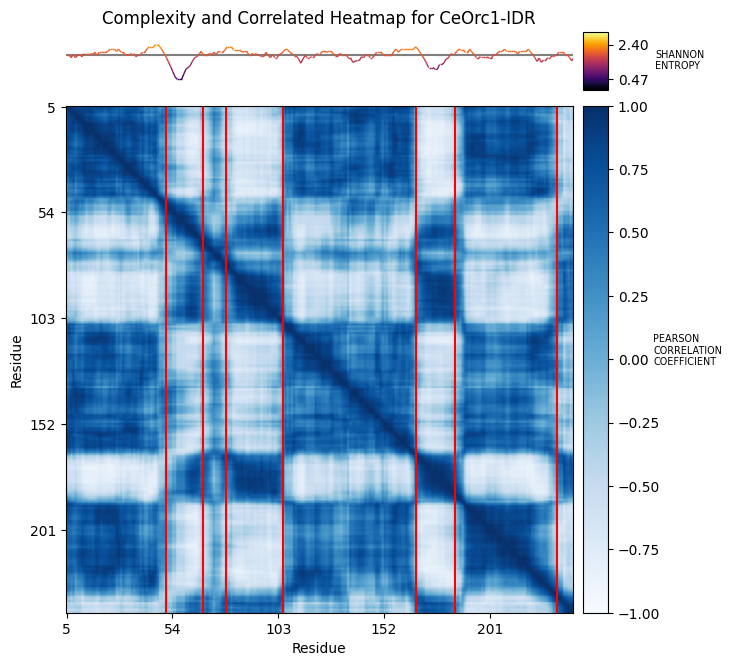

In [26]:
##### Specify desired output and generate results ##

## Enter desired confidence level. If possible, all boundaries in the output solution will be above this level. ##
## Enter 'ALL' for initial solution, otherwise enter one of the following values: 0, 50, 75, 80, 85, 90, 95, 99, 99.5 ##
confidence_level = 95


## Enter desired window size for graphic. The heatmap and local complexity plot will be generated using this window size. ##
## Enter any odd integer from 5 to 21 ##
window_size = 11

## Plot output with the following function. ##
solution, zscores = plot_results(confidence_level, window_size)

## Get actual solution, zscores, and resulting modules with this code ##
print(solution)
print(zscores)
modules = get_modules(sequence, solution)
mod_count = 0
while mod_count < len(modules):
    if mod_count == 0:
        start = 1
        end = int(solution[mod_count])
    elif mod_count == len(modules)-1:
        start = int(solution[mod_count-1]+1)
        end = int(len(sequence))
    else:
        start = int(solution[mod_count-1]+1)
        end = int(solution[mod_count])
    print('Module {} ({}-{}): {}'.format(str(mod_count+1), str(start), str(end), modules[mod_count]))
    mod_count = mod_count + 1
    
## Run this to save figure to desired path ##
plt.savefig('C:\\Users\\bmcco\\Desktop\\Chi_score\\Fig2 SVGs\\CeOrc1IDR_1195.svg', bbox_inches='tight')